# Data Eng 300 Homework 2

# Part 1

installing duckdb

In [2]:
!pip install duckdb==1.2.2
import duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 69.7 MB/s eta 0:00:00:00:0100:01


In [3]:
db_path = 'mimic_new.db'
conn = duckdb.connect('mimic_new.db')
conn.sql(
    """
    CREATE TABLE ADMISSIONS AS
      SELECT * FROM read_csv('ADMISSIONS.csv');

    CREATE TABLE ICUSTAYS AS
      SELECT * FROM read_csv('ICUSTAYS.csv');

    CREATE TABLE PATIENTS AS
      SELECT * FROM read_csv('PATIENTS.csv');

    CREATE TABLE PROCEDURES_ICD AS
      SELECT * FROM read_csv('PROCEDURES_ICD.csv');

    CREATE TABLE D_ICD_PROCEDURES AS
      SELECT * FROM read_csv('D_ICD_PROCEDURES.csv');

    CREATE TABLE DRGCODES AS
      SELECT * FROM read_csv('DRGCODES.csv');

    CREATE TABLE PRESCRIPTIONS AS
      SELECT * FROM read_csv('PRESCRIPTIONS.csv');

    """
)

In [4]:
print(conn.sql("SHOW TABLES;").fetchall())

[('ADMISSIONS',), ('DRGCODES',), ('D_ICD_PROCEDURES',), ('ICUSTAYS',), ('PATIENTS',), ('PRESCRIPTIONS',), ('PROCEDURES_ICD',)]


In [5]:
conn.sql('SHOW TABLES;')

┌──────────────────┐
│       name       │
│     varchar      │
├──────────────────┤
│ ADMISSIONS       │
│ DRGCODES         │
│ D_ICD_PROCEDURES │
│ ICUSTAYS         │
│ PATIENTS         │
│ PRESCRIPTIONS    │
│ PROCEDURES_ICD   │
└──────────────────┘

**1. Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.**

* consider total amount as number of instances, not as volume as drugs are administered in a variety of ways and many cannot be equivalent to the same measure.

In [6]:
conn.sql("""
WITH drug_count AS (
  SELECT
    ADMISSIONS.ethnicity,
    PRESCRIPTIONS.drug_type,
    COUNT(*) AS drug_count
  FROM ADMISSIONS
  JOIN PRESCRIPTIONS ON ADMISSIONS.hadm_id = PRESCRIPTIONS.hadm_id
  GROUP BY ADMISSIONS.ethnicity, PRESCRIPTIONS.drug_type
),

ranked_drugs AS (
  SELECT *,
    ROW_NUMBER() OVER (PARTITION BY ethnicity ORDER BY drug_count DESC) AS rank
  FROM drug_count
)

SELECT ethnicity, drug_type, drug_count
FROM ranked_drugs
WHERE rank = 1
ORDER BY ethnicity;
""")

┌──────────────────────────────────────────────────────────┬───────────┬────────────┐
│                        ethnicity                         │ drug_type │ drug_count │
│                         varchar                          │  varchar  │   int64    │
├──────────────────────────────────────────────────────────┼───────────┼────────────┤
│ AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE │ MAIN      │        200 │
│ ASIAN                                                    │ MAIN      │        121 │
│ BLACK/AFRICAN AMERICAN                                   │ MAIN      │        476 │
│ HISPANIC OR LATINO                                       │ MAIN      │        226 │
│ HISPANIC/LATINO - PUERTO RICAN                           │ MAIN      │        860 │
│ OTHER                                                    │ MAIN      │         72 │
│ UNABLE TO OBTAIN                                         │ MAIN      │         89 │
│ UNKNOWN/NOT SPECIFIED                               

In the SQL query for question 1, there are three main parts to it. First, the ethnicity, drug, and number of times the drug appears for each ethnicity is counted and returned as drug_count (by grouping by ethnicity). Total amount in this query is determined as number of instances because the units of measure for each drug varies and can often not yield an equivalent form of measure, for example a puff of one drug may not transfer well to mg of another. Therefore, frequency will be tracked instead. This requires the ADMISSIONS table to connect to PRESCRIPTIONS through hospital admissions (hadm_id) in order to account for every visit to the hospital. Next, the number of occurrences of drugs for each ethnicity is ranked from greatest to least (DESC) as a rank. Finally, ethnicity, drug, and drug_count are returned in a table in which only the top most (by the greatest number of instances) used drug was returned for each ethnicity (with rank 1).

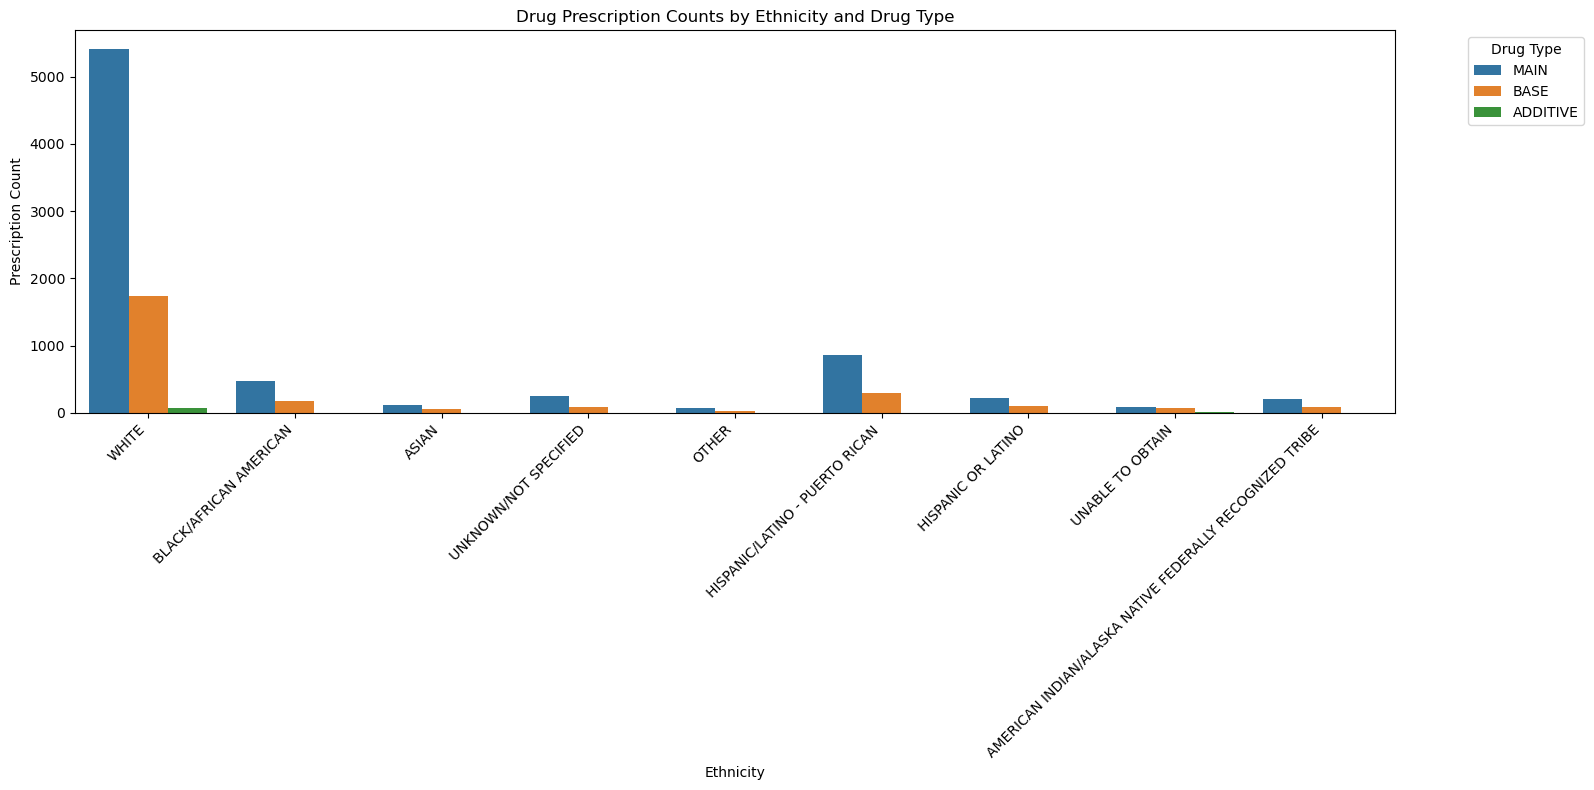

In [7]:
drug_df = conn.sql("""
WITH drug_count AS (
  SELECT
    ADMISSIONS.ethnicity,
    PRESCRIPTIONS.drug_type,
    COUNT(*) AS drug_count
  FROM ADMISSIONS
  JOIN PRESCRIPTIONS ON ADMISSIONS.hadm_id = PRESCRIPTIONS.hadm_id
  GROUP BY ADMISSIONS.ethnicity, PRESCRIPTIONS.drug_type
)
SELECT * FROM drug_count
""").df()

import matplotlib.pyplot as plt
import seaborn as sns

major_ethnicities = [
    'WHITE',
    'BLACK/AFRICAN AMERICAN',
    'ASIAN',
    'HISPANIC/LATINO - PUERTO RICAN',
    'UNKNOWN/NOT SPECIFIED',
    'HISPANIC OR LATINO',
    'UNABLE TO OBTAIN',
    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
    'OTHER'
]

filtered_df = drug_df[drug_df['ethnicity'].isin(major_ethnicities)]

plt.figure(figsize=(16, 8))

sns.barplot(
    data=filtered_df,
    x='ethnicity',
    y='drug_count',
    hue='drug_type'
)

plt.xticks(rotation=45, ha='right')
plt.title('Drug Prescription Counts by Ethnicity and Drug Type')
plt.xlabel('Ethnicity')
plt.ylabel('Prescription Count')
plt.legend(title='Drug Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


The table suggests that “MAIN” is the most common drug type across all ethnicities (returned as highest rank for each) which is also seen in the figure below. Here we see that “MAIN” leads with “BASE” being the second most common drug type across all ethnicities. It is interesting to notice that overall, there are the most prescription counts for those who visited whose ethnicity is white in this dataset. An interesting step further would be to consider the proportion of each type of drug for each ethnicity, and this is already explored on a basic level visually through the figure, noticing the ratio between “BASE” and “MAIN” is always yielding a higher proportion as “MAIN”.

**2. Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.**

- databases to use: patients for dob, dod
- I think add a column to calculate age based on dob and dod and then calculate range
- connect subject_id to that in procedures_icd, count the most common by icd9code
- return name of procedure by joining d_icd_procedure

to update age: note that every patient has a dob and dod

In [8]:
conn.sql(
    """
    ALTER TABLE ADMISSIONS
    ADD COLUMN age INT;
    """
)


In [9]:
conn.sql(
    """
    UPDATE ADMISSIONS
    SET age = (cast(admissions.admittime as date) - cast(patients.dob as date))/ 365.25
    FROM PATIENTS
    WHERE patients.subject_id = admissions.subject_id;
    """
)

In [ ]:
conn.sql('SHOW ADMISSIONS;')

┌──────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│     column_name      │ column_type │  null   │   key   │ default │  extra  │
│       varchar        │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ row_id               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ subject_id           │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ hadm_id              │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ admittime            │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ dischtime            │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ deathtime            │ TIMESTAMP   │ YES     │ NULL    │ NULL    │ NULL    │
│ admission_type       │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ admission_location   │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ discharge_location   │ VARCHAR     │ YES     │ NUL

In [10]:
conn.sql(
    """
    SELECT * FROM ADMISSIONS
    LIMIT 3;
    """
)

┌────────┬────────────┬─────────┬─────────────────────┬─────────────────────┬─────────────────────┬────────────────┬───────────────────────────┬────────────────────┬───────────┬──────────┬──────────┬────────────────┬────────────────────────┬─────────────────────┬─────────────────────┬─────────────┬──────────────────────┬──────────────────────┬───────┐
│ row_id │ subject_id │ hadm_id │      admittime      │      dischtime      │      deathtime      │ admission_type │    admission_location     │ discharge_location │ insurance │ language │ religion │ marital_status │       ethnicity        │      edregtime      │      edouttime      │  diagnosis  │ hospital_expire_flag │ has_chartevents_data │  age  │
│ int64  │   int64    │  int64  │      timestamp      │      timestamp      │      timestamp      │    varchar     │          varchar          │      varchar       │  varchar  │ varchar  │ varchar  │    varchar     │        varchar         │      timestamp      │      timestamp      │   varc

In [11]:
conn.sql(
    """
    WITH patient_procedures AS (
    SELECT
        ADMISSIONS.hadm_id,
        D_ICD_PROCEDURES.short_title AS procedure_name,
        CASE
            WHEN ADMISSIONS.age <= 19 THEN '0-19'
            WHEN ADMISSIONS.age BETWEEN 20 AND 49 THEN '20-49'
            WHEN ADMISSIONS.age BETWEEN 50 AND 79 THEN '50-79'
            ELSE '>80'
        END AS age_group
    FROM ADMISSIONS
    JOIN PROCEDURES_ICD ON ADMISSIONS.hadm_id = PROCEDURES_ICD.hadm_id
    JOIN D_ICD_PROCEDURES ON PROCEDURES_ICD.icd9_code = D_ICD_PROCEDURES.icd9_code
),

procedure_counts AS (
    SELECT
        age_group,
        procedure_name,
        COUNT(*) AS procedure_count
    FROM patient_procedures
    GROUP BY age_group, procedure_name
),

ranked_procedures AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY age_group ORDER BY procedure_count DESC) AS rank
    FROM procedure_counts
)

SELECT age_group, procedure_name, procedure_count
FROM ranked_procedures
WHERE rank <= 3
ORDER BY age_group, rank;

    """
)

┌───────────┬──────────────────────────┬─────────────────┐
│ age_group │      procedure_name      │ procedure_count │
│  varchar  │         varchar          │      int64      │
├───────────┼──────────────────────────┼─────────────────┤
│ 0-19      │ Venous cath NEC          │               2 │
│ 0-19      │ Vertebral fx repair      │               1 │
│ 0-19      │ Interruption vena cava   │               1 │
│ 20-49     │ Venous cath NEC          │               9 │
│ 20-49     │ Entral infus nutrit sub  │               7 │
│ 20-49     │ Insert endotracheal tube │               6 │
│ 50-79     │ Venous cath NEC          │              25 │
│ 50-79     │ Entral infus nutrit sub  │              22 │
│ 50-79     │ Packed cell transfusion  │              13 │
│ >80       │ Venous cath NEC          │              20 │
│ >80       │ Packed cell transfusion  │              13 │
│ >80       │ Insert endotracheal tube │               8 │
├───────────┴──────────────────────────┴────────────────

After using the date of birth and date of death from PATIENTS to determine the age of each patient in the database, the query itself has three main parts to it. First, within patient_procedures, CASE is used to create the distinction between each age range in order to seperate the rest of the information by age category. Additionally, PATIENTS, PROCEDURES_ICD, and D_ICD_PROCEDURES are all joined together to integrate information on subject id (who each individual is) and icd9_code (the numerical representation of each procedure) to generate the name associated with each procedure and to each patient. Second, the procedure_counts group counts the number of each procedure within each age category to return the total number of individuals in that category to have that procedure done to them. Finally, the ranked_procedures ensures that within the table the procedures are ranked from most frequent to least and the top three are returned.

The resulting table is ordered by age group (from youngest to oldest) then lists the most frequent procedures with the number of individuals in that group returned with it. Note that there is no <=19 category which is why there are no values returned for it in the table.

From the table, it is clear that Venous cath NEC is the most common procedure across age groups because it is ranked first for all of them. For 20-79, Entral infus nutrit sub is next common, which deviates from next common for >=80 (Packed cell transfusion). The Packed cell transfustion does however appear as the thirst most common procedure for 50-79 which indicates that its frequency appears to pick up with age, although as the table is not standardized by proportion or equal numbers of individuals in that age group per sample we cannot claim that there is a relationship between this procedure and increased age.

**3. How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?**


- use ICUSTAYS to calculate outtime-intime for each subject id. Maybe make a graph for this? and calculate mean/median/standard dev etc.

- link to subjectID for patients and admissions, then graph and take average/ measures of spread for gender and ethnicity

In [12]:
conn.sql("""
SELECT ICUSTAYS.outtime FROM ICUSTAYS LIMIT 3;
""")

┌─────────────────────┐
│       outtime       │
│      timestamp      │
├─────────────────────┤
│ 2164-10-25 12:21:07 │
│ 2126-08-28 18:59:00 │
│ 2125-10-07 15:13:52 │
└─────────────────────┘

In [13]:
conn.sql(
    """
    ALTER TABLE ICUSTAYS
    ADD COLUMN stay_length INT;
    """
)

In [14]:
conn.sql(
    """
    UPDATE ICUSTAYS
    SET stay_length = (cast(ICUSTAYS.outtime as date) - cast(ICUSTAYS.intime as date));
    """
)

In [15]:
conn.sql("""
SELECT ICUSTAYS.stay_length FROM ICUSTAYS;
""")

┌─────────────┐
│ stay_length │
│    int32    │
├─────────────┤
│           2 │
│          14 │
│           3 │
│           2 │
│           2 │
│           2 │
│           7 │
│           2 │
│           3 │
│           1 │
│           · │
│           · │
│           · │
│           1 │
│           0 │
│           1 │
│           2 │
│           2 │
│           3 │
│           1 │
│          31 │
│           1 │
│           4 │
├─────────────┤
│  136 rows   │
│ (20 shown)  │
└─────────────┘

In [16]:
conn.sql("""
SELECT * FROM ICUSTAYS LIMIT 3;
""")

┌────────┬────────────┬─────────┬────────────┬──────────┬────────────────┬───────────────┬──────────────┬─────────────┬─────────────────────┬─────────────────────┬─────────┬─────────────┐
│ row_id │ subject_id │ hadm_id │ icustay_id │ dbsource │ first_careunit │ last_careunit │ first_wardid │ last_wardid │       intime        │       outtime       │   los   │ stay_length │
│ int64  │   int64    │  int64  │   int64    │ varchar  │    varchar     │    varchar    │    int64     │    int64    │      timestamp      │      timestamp      │ double  │    int32    │
├────────┼────────────┼─────────┼────────────┼──────────┼────────────────┼───────────────┼──────────────┼─────────────┼─────────────────────┼─────────────────────┼─────────┼─────────────┤
│  12742 │      10006 │  142345 │     206504 │ carevue  │ MICU           │ MICU          │           52 │          52 │ 2164-10-23 21:10:15 │ 2164-10-25 12:21:07 │  1.6325 │           2 │
│  12747 │      10011 │  105331 │     232110 │ carevue  │ MI

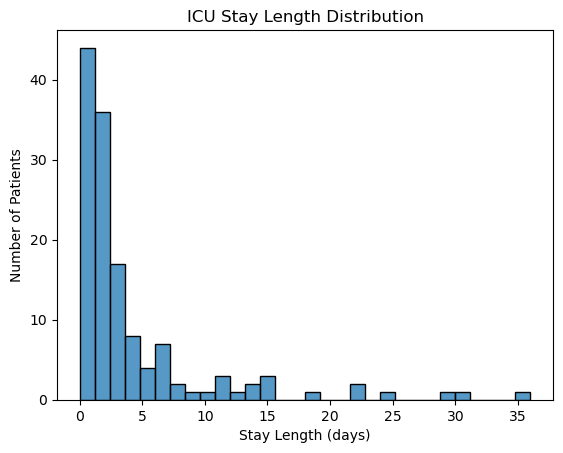

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

icu_stay_df = conn.sql("SELECT stay_length FROM ICUSTAYS WHERE stay_length IS NOT NULL").df()

sns.histplot(data=icu_stay_df, x='stay_length', bins=30)
plt.title('ICU Stay Length Distribution')
plt.xlabel('Stay Length (days)')
plt.ylabel('Number of Patients')
plt.show()

In [18]:
q1 = icu_stay_df['stay_length'].quantile(0.25)
median = icu_stay_df['stay_length'].median()
q3 = icu_stay_df['stay_length'].quantile(0.75)
mean = icu_stay_df['stay_length'].mean()
std = icu_stay_df['stay_length'].std()

print(f"Q1: {q1}, Median: {median}, Q3: {q3}, Mean: {mean}, Std: {std}")

Q1: 1.0, Median: 2.0, Q3: 4.0, Mean: 4.426470588235294, Std: 6.201113822223035


For all values in stay_length, The distribution for ICU stay length is heavily skewed right with the median at 2 days and the mean around 4.42 days. It is evident from the histogram that most patients stay between 1 and 4 days (see Fig. 2).

In [19]:
icu_stays_gender = conn.sql("""
    SELECT PATIENTS.gender, ICUSTAYS.stay_length
    FROM ICUSTAYS
    JOIN ADMISSIONS ON ICUSTAYS.hadm_id = ADMISSIONS.hadm_id
    JOIN PATIENTS ON ADMISSIONS.subject_id = PATIENTS.subject_id
    WHERE ICUSTAYS.stay_length IS NOT NULL
""").df()

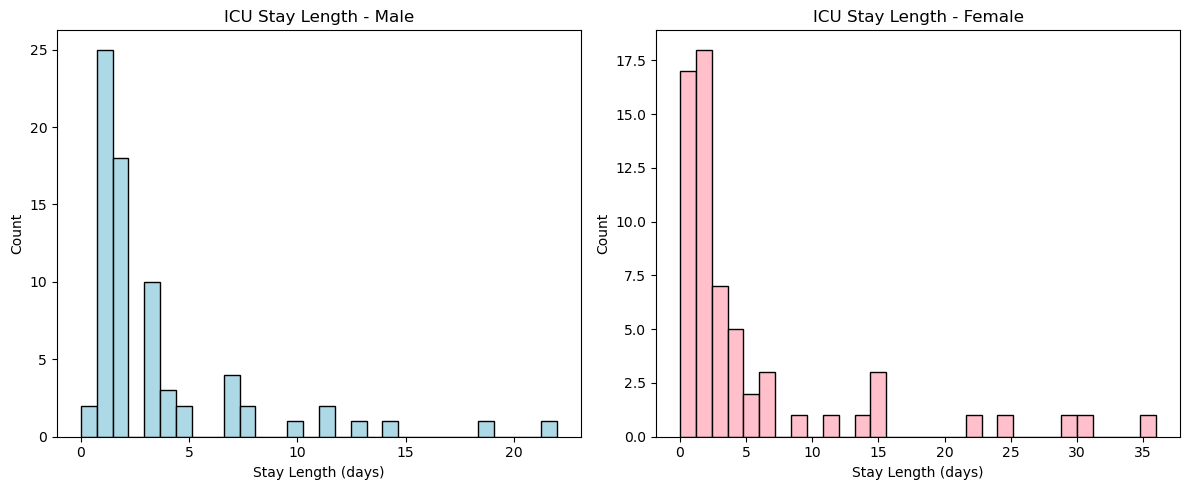

In [20]:
import matplotlib.pyplot as plt

gender_m = icu_stays_gender[icu_stays_gender['gender'] == 'M']
gender_f = icu_stays_gender[icu_stays_gender['gender'] == 'F']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(gender_m['stay_length'], bins=30, color='lightblue', edgecolor='black')
plt.title('ICU Stay Length - Male')
plt.xlabel('Stay Length (days)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(gender_f['stay_length'], bins=30, color='pink', edgecolor='black')
plt.title('ICU Stay Length - Female')
plt.xlabel('Stay Length (days)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [21]:
q1 = gender_m['stay_length'].quantile(0.25)
median = gender_m['stay_length'].median()
q3 = gender_m['stay_length'].quantile(0.75)
mean = gender_m['stay_length'].mean()
std = gender_m['stay_length'].std()
count = gender_m['stay_length'].count()

print(f"Q1: {q1}, Median: {median}, Q3: {q3}, Mean: {mean}, Std: {std}, Count: {count}")

Q1: 1.0, Median: 2.0, Q3: 3.0, Mean: 3.5205479452054793, Std: 4.177019102718456, Count: 73


In [22]:
q1 = gender_f['stay_length'].quantile(0.25)
median = gender_f['stay_length'].median()
q3 = gender_f['stay_length'].quantile(0.75)
mean = gender_f['stay_length'].mean()
std = gender_f['stay_length'].std()
count = gender_f['stay_length'].count()

print(f"Q1: {q1}, Median: {median}, Q3: {q3}, Mean: {mean}, Std: {std}, Count: {count}")

Q1: 1.0, Median: 2.0, Q3: 4.5, Mean: 5.476190476190476, Std: 7.834697727370387, Count: 63


 In the next set of data, for males in the ICU, the median is still at 2 but the mean has shifted to 3.52 days, with a smaller standard deviation at 4.18 suggesting a smaller spread which makes sense as there is a smaller skew in the data. Additionally, the IQR is only 2 days, while for all the data points it was 3 (1 to 4 days), suggesting a smaller spread as well (see Fig. 3). For females, the median remains at 2 but the spread of data is much larger than for males, as the IQR (from 1 to 4.5) is 3.5 days, and the mean is much farther from the median at 5.48 days with a standard deviation at 7.8 days. The skew appears to be greater in this set as there is an individual who stayed in the ICU for 35 days, which is more than 6 days longer than the individual who stayed the longest in the male data (22 days) (see Fig. 4).

In [23]:
icu_stays_ethnicity = conn.sql("""
    SELECT ADMISSIONS.ethnicity, ICUSTAYS.stay_length
    FROM ICUSTAYS
    JOIN ADMISSIONS ON ICUSTAYS.hadm_id = ADMISSIONS.hadm_id
    WHERE ICUSTAYS.stay_length IS NOT NULL
""").df()

In [24]:
major_ethnicities = [
    'WHITE',
    'BLACK/AFRICAN AMERICAN',
    'ASIAN',
    'HISPANIC/LATINO - PUERTO RICAN',
    'UNKNOWN/NOT SPECIFIED',
    'HISPANIC OR LATINO',
    'UNABLE TO OBTAIN',
    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
    'OTHER'
]

icu_stays_ethnicity_filtered = icu_stays_ethnicity[
    icu_stays_ethnicity['ethnicity'].isin(major_ethnicities)
]

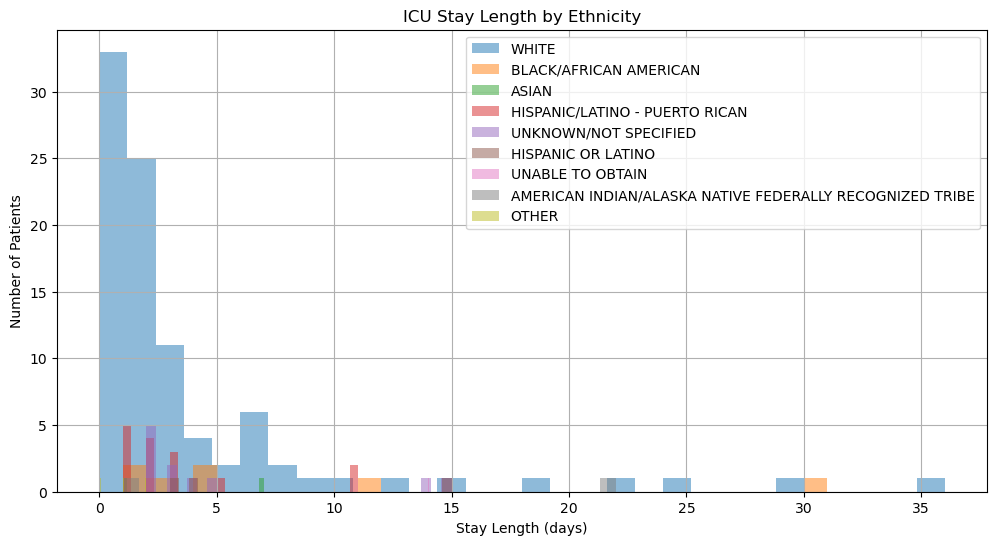

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for ethnicity in major_ethnicities:
    subset = icu_stays_ethnicity_filtered[icu_stays_ethnicity_filtered['ethnicity'] == ethnicity]
    plt.hist(subset['stay_length'], bins=30, alpha=0.5, label=ethnicity)

plt.title('ICU Stay Length by Ethnicity')
plt.xlabel('Stay Length (days)')
plt.ylabel('Number of Patients')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
ethnicity_stats = icu_stays_ethnicity_filtered.groupby('ethnicity')['stay_length'].agg(
    Count= 'count',
    Q1=lambda x: x.quantile(0.25),
    Median='median',
    Q3=lambda x: x.quantile(0.75),
    Mean='mean',
    Std='std'
).reset_index()

print(ethnicity_stats)

                                           ethnicity  Count     Q1  Median  \
0  AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...      2   6.25    11.5   
1                                              ASIAN      2   2.50     4.0   
2                             BLACK/AFRICAN AMERICAN      7   1.50     4.0   
3                                 HISPANIC OR LATINO      3   3.50     4.0   
4                     HISPANIC/LATINO - PUERTO RICAN     15   1.00     2.0   
5                                              OTHER      3   0.50     1.0   
6                                   UNABLE TO OBTAIN      1  14.00    14.0   
7                              UNKNOWN/NOT SPECIFIED     11   2.00     3.0   
8                                              WHITE     92   1.00     2.0   

      Q3       Mean        Std  
0  16.75  11.500000  14.849242  
1   5.50   4.000000   4.242641  
2   7.50   7.714286  10.827654  
3   9.50   7.333333   6.658328  
4   3.00   3.266667   3.326660  
5   1.50   1.000000  

From the last dataset, there is a much bigger range of differences between ethnicities than for gender. For example, for the category "AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE" it is identified that the median is 11.5 days with an IQR from 1 to 22 days. This is also characterized by there being less individuals with that ethnicity in the dataset, so these measures are not reflective of people of this ethnicity overall, just in terms of the data presented in this set. White individuals are more closely aligned to the initial spread of all the data with a median of 2 days (same as intial) and an IQR from 1 to 3 days (initial was 1 to 4 days). The mean also falls at 4.02, similar to the mean of the initial set at 4.42 days. There is a greater number of White individuals (122) in the dataset compared to American Indian/Alaska Native (4), so it makes sense for the measures of spread to more closely align to the overall (see Fig. 5).
